<a href="https://colab.research.google.com/github/samade123/deep_learning_project/blob/main/cifar10_Universal_adversarial_perturbations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install git+https://github.com/tensorflow/cleverhans.git#egg=cleverhans
# !pip install progress
# load tqdm
!pip install --force https://github.com/chengs/tqdm/archive/colab.zip

%tensorflow_version 2.x  # this line is not required unless you are in a notebook
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras
import cleverhans
keras.__version__
# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas
# from progress.bar import Bar
from tqdm import tqdm_notebook as tqdm


print("\nTensorflow Version: " + tf.__version__)
print("Cleverhans Version: " + cleverhans.__version__)
print("GPU Available: ", tf.test.is_gpu_available())

  Using cached https://github.com/chengs/tqdm/archive/colab.zip
  Created wheel for tqdm: filename=tqdm-4.28.1-py2.py3-none-any.whl size=47868 sha256=dc72748ce433161cd1a55cc8f69b58da47e05084e9e9a687974257cbc67b0dbf
  Stored in directory: /tmp/pip-ephem-wheel-cache-tv0s_dpg/wheels/41/18/ee/d5dd158441b27965855b1bbae03fa2d8a91fe645c01b419896
Successfully built tqdm
ERROR: spacy 2.2.4 has requirement tqdm<5.0.0,>=4.38.0, but you'll have tqdm 4.28.1 which is incompatible.
ERROR: fbprophet 0.7.1 has requirement tqdm>=4.36.1, but you'll have tqdm 4.28.1 which is incompatible.
  Found existing installation: tqdm 4.28.1
    Uninstalling tqdm-4.28.1:
      Successfully uninstalled tqdm-4.28.1


`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `2.x  # this line is not required unless you are in a notebook`. This will be interpreted as: `2.x`.


TensorFlow is already loaded. Please restart the runtime to change versions.

Tensorflow Version: 2.4.1
Cleverhans Version: 4.0.0-dda3ed9309fe3cd6d5b746c5c9c440d8
GPU Available:  False


In [ ]:
# Recreate the exact same model, including its weights and the optimizer
new_model = tf.keras.models.load_model('cifar_2.h5')

# Show the model architecture
# new_model.summary()

In [ ]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.cifar10.load_data()

# Normalize pixel values to be between 0 and 1
train_images, test_images = train_images / 255.0, test_images / 255.0

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

170500096/170498071 [==============================] - 2s 0us/step


In [ ]:

def show_image(img, label="", guess=""):
  plt.figure()
  plt.imshow(img, cmap=plt.cm.binary)
  plt.title("Expected: " + label)
  plt.xlabel("Guess: " + guess)
  plt.colorbar()
  plt.grid(False)
  plt.show()

def predict(model, image, correct_label, num):
#   class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
#                'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
  prediction = model.predict(np.array([image]))
  predicted_class = class_names[np.argmax(prediction)]

#   print(prediction, predicted_class)
  image = test_images[num]
  show_image(image, class_names[correct_label], predicted_class)


def get_number():
  while True:
    num = input("Pick a number: ")
    if num.isdigit():
      num = int(num)
      if 0 <= num <= 1000:
        return int(num)
    else:
      print("Try again...")

def     select_number(num=0):
    return_val = False
    if num == 0:
        num = get_number()
        return_val = True
    image = test_images[num]
    label = test_labels[num]
    predict(new_model, image, label, num)
    if return_val:
        return num

def show_convoluted_image(original_image, original_label, guess):
    #Show the image
    plt.figure()
    plt.grid(False)
    original_label = class_names[original_label]
    guess = class_names[guess]

    plt.imshow(np.reshape(original_image, (32,32, 3)))
    plt.title("Model Prediction: {}".format(guess))
    plt.xlabel("Original Label: {}".format(original_label))


    plt.show()        

In [ ]:
# select_number()

#Part 2: The Fast Gradient Method (FGM)

In [ ]:
# Import the attack
from cleverhans.tf2.attacks.fast_gradient_method import fast_gradient_method

#The attack requires the model to ouput the logits
logits_model = tf.keras.Model(new_model.input,new_model.layers[-1].output)

In [ ]:
def fsgm(index, original_image,  epsilon = 0.03, verbose_log = False):
    # original_image = conv_train_images[index]
    original_image = tf.convert_to_tensor(original_image.reshape((32,32,3))) #The .reshape just gives it the proper form to input into the model, a batch of 1 a.k.a a tensor
    original_image = np.expand_dims(original_image, axis=0)

    original_label = train_labels[index]
    original_label = np.reshape(original_label, (1,)).astype('int64') # Give label proper shape and type for cleverhans
    if verbose_log == True:
        select_number(index)
        show_convoluted_image(original_image, original_label[0], original_label[0])
    

    adv_example_untargeted_label = fast_gradient_method(logits_model, original_image, epsilon, np.inf, targeted=False)

    adv_example_untargeted_label_pred = new_model.predict(adv_example_untargeted_label)

    return adv_example_untargeted_label, adv_example_untargeted_label_pred

def get_pertubation(original_image, adv_example_untargeted_label):
    pertubation = original_image - adv_example_untargeted_label
    return pertubation

def get_max_prediction(model_predicition):
    return model_predicition[0][np.argmax(model_predicition)]   

def is_new_iamge_fooled(adv_prediction, prediction_old, fooling_rate, verbose_log = False):
    if verbose_log == True:
        print("fooling_rate", fooling_rate)
        print("fooling_rate", prediction_old)
        print("adverse Image prediction: " , np.argmax(adv_prediction) , "val: ", np.max(adv_prediction)  ,", origiinal Image prediction: ", np.argmax(prediction_old), "val: ", np.max(prediction_old),  ", prediction accuracy greater than fooling rate: ", get_max_prediction(adv_prediction) > fooling_rate )
        # class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
        #        'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
        # table = pandas.DataFrame(adv_prediction.transpose(), class_names, ['old'])
        # prediction_old = new_model.predict(original_image)
        new_data = np.concatenate((adv_prediction, prediction_old))
        table = pandas.DataFrame(new_data.transpose(), class_names, ['new', 'old'])
        print(table)
        print(np.max(adv_prediction/np.sum(adv_prediction))*100)
        print("are max index the same", (np.argmax(adv_prediction) != np.argmax(prediction_old), ", higher than foolng rte", get_max_prediction(adv_prediction) > fooling_rate ))
        print("is the adverse Image foolwortgy: ", (np.argmax(adv_prediction) != np.argmax(prediction_old)) and (get_max_prediction(adv_prediction) > fooling_rate ))
        table.to_csv('data.csv')
    return ((np.argmax(adv_prediction) != np.argmax(prediction_old)) and (get_max_prediction(adv_prediction) > fooling_rate ))  

def minimum_fsgm(fooling_rate, original_image, random_index, verbose_log=False):
    prediction_old = new_model.predict(original_image)

    a_adv_pred = prediction_old
    x_adv = original_image
    # x_adv, a_adv_pred = fsgm(random_index)
    itr = 2
    max_attempts = 20
    epislon_steps = 0.01
    # current_fooling_rate = 0
    # while 

    # if first_image == True:
        # while ((np.argmax(a_adv_pred) == np.argmax(prediction_old)) or (get_max_prediction(a_adv_pred) < fooling_rate )):
    status = True
    if verbose_log:
        print("does while statement run", is_new_iamge_fooled(a_adv_pred, prediction_old, fooling_rate, False))
    while is_new_iamge_fooled(a_adv_pred, prediction_old, fooling_rate, False) == False:
        itr+= 1
        if verbose_log:
            print(itr , epislon_steps*itr, is_new_iamge_fooled(a_adv_pred, prediction_old, fooling_rate))
        x_adv, a_adv_pred = fsgm(random_index, original_image, epislon_steps*itr)
        if itr > max_attempts: 
            status = False
            break

    pertubation = get_pertubation(original_image, x_adv)
    return pertubation, status


def create_universerial_pertubations(loops = 10, fooling_rate=0.5, verbose_log =False):
    image_index = 0
    # fooling_rate = 0.9
    pbar = tqdm(total=loops)

    while image_index < loops:
        random_index = np.random.randint(train_images.shape[0])
        original_image = train_images[random_index]
        original_image = tf.convert_to_tensor(original_image.reshape((32,32,3))) #The .reshape just gives it the proper form to input into the model, a batch of 1 a.k.a a tensor
        original_image = np.expand_dims(original_image, axis=0)

        original_label = train_labels[train_labels[random_index][0]]
        original_label = np.reshape(original_label, (1,)).astype('int64') # Give label proper shape and type for cleverhans
        # original_label = class_names[train_labels[random_index][0]]


        prediction_old = new_model.predict(original_image)
        # print("first_image")
        first_image = (image_index == 0)
        # current_pertubation = minimum_fsgm(fooling_rate, first_image)
        if first_image == True:
            current_pertubation, status = minimum_fsgm(fooling_rate, original_image, random_index) #fix minimum fgsm function
            show_convoluted_image(current_pertubation, original_label[0], original_label[0])

            universal_pertubation = current_pertubation
        else:
            pertubated_img = original_image + universal_pertubation
            prediction_old = new_model.predict(original_image)
            predicion_pertubated = new_model.predict(pertubated_img)
            if is_new_iamge_fooled(predicion_pertubated, prediction_old, fooling_rate, verbose_log):
                # image_index+= 1
                if verbose_log:
                    print("image is fooled", image_index)
                # loops+= 1
                
            else: 
                current_pertubation, status = minimum_fsgm(fooling_rate, original_image, random_index)
                if verbose_log:
                    print("image is being pertubated", image_index)

                # attempt 1 - queit but not adverserial
                # difference_pert =universal_pertubation - current_pertubation
                # universal_pertubation = difference_pert - universal_pertubation

                # attempt 2 - works but the pertubation is not qiuet
                # difference_pert = np.abs(current_pertubation - universal_pertubation)
                # universal_pertubation = universal_pertubation + difference_pert

                # attempt 3 - works but the pertubation is not qiuet
                # difference_pert = np.abs(universal_pertubation - current_pertubation)
                # universal_pertubation = universal_pertubation + difference_pert

                # difference_pert =  current_pertubation - universal_pertubation
                # universal_pertubation = universal_pertubation + difference_pert

                # attempt 4 - not yet tested
                # difference_pert = np.abs(universal_pertubation - current_pertubation)
                # universal_pertubation = np.abs(difference_pert - universal_pertubation)

                 # attempt 4 - not yet tested
                # difference_pert = universal_pertubation - current_pertubation
                # universal_pertubation = np.abs(universal_pertubation - difference_pert)

                # universal_pertubation = universal_pertubation + current_pertubation
               
                universal_pertubation =np.abs(universal_pertubation - current_pertubation)

                # universal_pertubation =np.abs(current_pertubation - universal_pertubation)

                if verbose_log:
                    show_convoluted_image(difference_pert, original_label[0], original_label[0])
                    show_convoluted_image(current_pertubation, original_label[0], original_label[0])
                    show_convoluted_image(universal_pertubation, original_label[0], original_label[0])

                # image_index+= 1


        if status == True:
            image_index+= 1
            pbar.update(1)
    pbar.close()
    return universal_pertubation

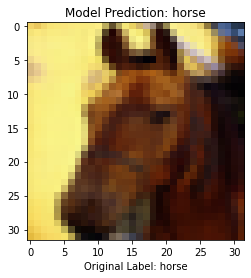

In [ ]:
random_index = np.random.randint(train_images.shape[0])

original_image = train_images[random_index]
original_image = tf.convert_to_tensor(original_image.reshape((32,32,3))) #The .reshape just gives it the proper form to input into the model, a batch of 1 a.k.a a tensor
original_image = np.expand_dims(original_image, axis=0)

original_label = train_labels[random_index]
original_label = np.reshape(original_label, (1,)).astype('int64') # Give label proper shape and type for cleverhans

# #Show the image
# plt.figure()
# plt.grid(False)

# plt.imshow(np.reshape(original_image, (28,28)))
# plt.title("Label: {}".format(original_label[0]))

# plt.show()
# select_number(random_index)
show_convoluted_image(original_image, original_label[0], original_label[0])

### Non-targeted FGSM attack


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


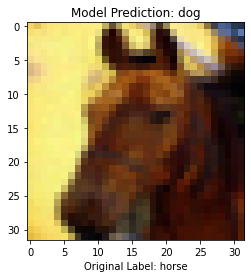

In [ ]:
epsilon = 0.01

adv_example_untargeted_label = fast_gradient_method(logits_model, original_image, epsilon, np.inf, targeted=False)

adv_example_untargeted_label_pred = new_model.predict(adv_example_untargeted_label)

# #Show the image
# plt.figure()
# plt.grid(False)

# plt.imshow(np.reshape(adv_example_untargeted_label, (28,28)))
# plt.title("Model Prediction: {}".format(np.argmax(adv_example_untargeted_label_pred)))
# plt.xlabel("Original Label: {}".format(original_label[0]))

# plt.show()
# print("Prediction", adv_example_untargeted_label_pred)
show_convoluted_image(adv_example_untargeted_label, original_label[0], np.argmax(adv_example_untargeted_label_pred))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


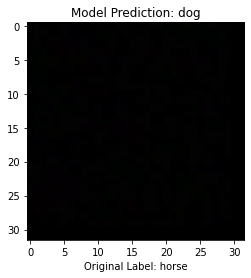

In [ ]:
pertubation = original_image - adv_example_untargeted_label
# #Show the image
# plt.figure()
# plt.grid(False)

# plt.imshow(np.reshape(pertubation, (28,28)))
# plt.title("Model Prediction: {}".format(np.argmax(adv_example_untargeted_label_pred)))
# plt.xlabel("Original Label: {}".format(original_label[0]))

# plt.show()
show_convoluted_image(pertubation, original_label[0], np.argmax(adv_example_untargeted_label_pred))


In [ ]:
# is_new_iamge_fooled(adv_example_untargeted_label_pred, prediction_old, 0.6, True) 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


does while statement run False
3 0.03 False
True


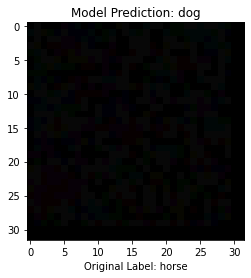

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


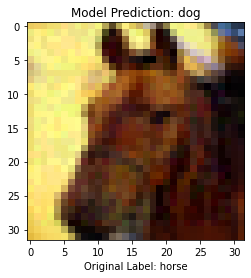

fooling_rate 0.4
fooling_rate [[0.00001299 0.00000933 0.00316391 0.01703677 0.00293586 0.01473698
  0.00035485 0.9615193  0.00000151 0.00022848]]
adverse Image prediction:  7 val:  0.9999949 , origiinal Image prediction:  7 val:  0.9615193 , prediction accuracy greater than fooling rate:  True
                     new       old
airplane    1.720781e-08  0.000013
automobile  3.130729e-09  0.000009
bird        9.864884e-07  0.003164
cat         1.290648e-06  0.017037
deer        1.325042e-06  0.002936
dog         8.702609e-07  0.014737
frog        1.783499e-07  0.000355
horse       9.999949e-01  0.961519
ship        3.499299e-10  0.000002
truck       4.533138e-07  0.000228
99.99948740005493
are max index the same (False, ', higher than foolng rte', True)
is the adverse Image foolwortgy:  False


False

In [ ]:
 y, r = minimum_fsgm(0.6, original_image, random_index, True)
 print(r)

 pertubed = original_image + y
show_convoluted_image(y, original_label[0], np.argmax(adv_example_untargeted_label_pred))
show_convoluted_image(pertubed, original_label[0], np.argmax(adv_example_untargeted_label_pred))
np.set_printoptions(formatter={'float_kind':'{:f}'.format})
np.set_printoptions(suppress=True)
pertubed_min_pred = new_model.predict(pertubed)
prediction_old = new_model.predict(original_image)

is_new_iamge_fooled(pertubed_min_pred, prediction_old, 0.4, True) 
# show_convoluted_image(y, original_label[0], np.argmax(adv_example_untargeted_label_pred))


/usr/local/lib/python3.7/dist-packages/tqdm/_tqdm_notebook.py:88: TqdmExperimentalWarning: Detect Google Colab 0.0.1a2 and thus load dummy ipywidgets package. Note that UI is different from that in Jupyter. See https://github.com/tqdm/tqdm/pull/640
  " See https://github.com/tqdm/tqdm/pull/640".format(colab.__version__), TqdmExperimentalWarning)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


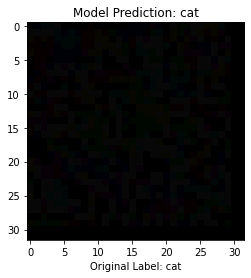

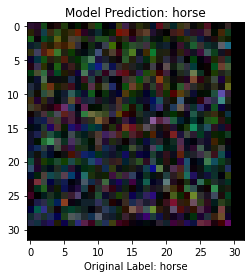

In [ ]:
universal = create_universerial_pertubations(50, 0.1, False)
show_convoluted_image(universal, original_label[0], original_label[0])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[2]
fooling_rate 0.4
fooling_rate [[0.01563624 0.00114282 0.43071178 0.2473858  0.00338125 0.03027977
  0.04851937 0.19279629 0.02540275 0.00474389]]
adverse Image prediction:  6 val:  0.8154465 , origiinal Image prediction:  2 val:  0.43071178 , prediction accuracy greater than fooling rate:  True
                 new       old
airplane    0.000045  0.015636
automobile  0.000357  0.001143
bird        0.116069  0.430712
cat         0.023959  0.247386
deer        0.023024  0.003381
dog         0.001894  0.030280
frog        0.815446  0.048519
horse       0.004668  0.192796
ship        0.001642  0.025403
truck       0.012896  0.004744
81.54466152191162
are max index the same (True, ', higher than foolng rte', True)
is the adverse Image foolwortgy:  True


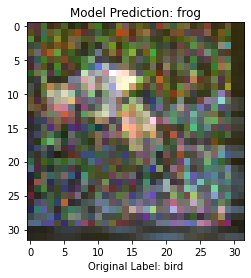

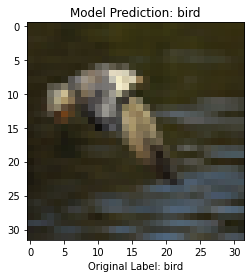

In [ ]:
def test_universal(universal):
    random_index = np.random.randint(test_images.shape[0])
    original_image = test_images[random_index]
    original_image = tf.convert_to_tensor(original_image.reshape((32,32,3))) #The .reshape just gives it the proper form to input into the model, a batch of 1 a.k.a a tensor
    original_image = np.expand_dims(original_image, axis=0)
    original_label = test_labels[random_index]
    original_label = np.reshape(original_label, (1,)).astype('int64') # Give label proper shape and type for cleverhans
    print(original_label)

    new_image = original_image + universal

    prediction_old = new_model.predict(original_image)
    prediction_new = new_model.predict(new_image)

    is_new_iamge_fooled(prediction_new, prediction_old, 0.4, True)
    show_convoluted_image(new_image, original_label[0], np.argmax(prediction_new))
    show_convoluted_image(original_image, original_label[0], np.argmax(prediction_old))


test_universal(universal)


# Debugging errors

In [ ]:
from __future__ import print_function

def valid_imshow_data(data):
    data = np.asarray(data)
    if data.ndim == 2:
        return True
    elif data.ndim == 3:
        if 3 <= data.shape[2] <= 4:
            return True
        else:
            print('The "data" has 3 dimensions but the last dimension '
                  'must have a length of 3 (RGB) or 4 (RGBA), not "{}".'
                  ''.format(data.shape[2]))
            return False
    else:
        print('To visualize an image the data must be 2 dimensional or '
              '3 dimensional, not "{}".'
              ''.format(data.ndim))
        return False

valid_imshow_data(test_images[3])


True

If the code above returns false then there is something likely wrong with the image data 